<a href="https://colab.research.google.com/github/AnnaZhuravleva/compling/blob/master/assignment_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 6

[3 points] Delelop language model, which generates texts from wikipedia.   
Use WikiText-2 dataset, also available in `torchtext.datasets`.  
Use `sentencepiece` or `tokenizers` library for text tokenization. Pay attention to vocab size, probably subword tokens are better.    
Your model should be autogressive RNN.  
[1 point] Plot train and validation loss depending on the number of iterations of gradient decent.  
[1 point] Try to use together (`sentencepiece` or `tokenizers`), `torchtext.datasets`, and `torchtext.data.BPTTIterator`  

<img src="https://github.com/thedenaas/hse_seminars/blob/master/2019/seminar_9/images/lm.jpg?raw=1" style="height:300px">

Text generation should be terminated when either max length is reached or terminal symbol is generated.  
Explore several inference techniques:
1. [1 point] Argmax
1. [1 point] Beamsearch
1. [1 point] Sampling from probabilty distribution with temperature
1. [1 point] Nucleus sampling
1. [1 point] Top-k sampling


For every method you should provide implemented code and generated examples. Each example must contain at least 10 words (not subword tokens).

Readings:
https://arxiv.org/abs/1904.09751

In [1]:
import torchtext
import pandas as pd
import numpy as np
from sklearn.externals import joblib
import nltk
nltk.download('stopwords')
import gensim
import spacy
from tqdm import tqdm_notebook

from sklearn import metrics

import torch as tt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable as V
from torchtext.data import Field, LabelField, BucketIterator, ReversibleField
from torchtext.datasets import WikiText2


SEED = 42
np.random.seed(SEED)
np.random.seed(42)

from torchtext import data
import spacy


spacy_en = spacy.load('en')
spacy_en.remove_pipe('tagger')
spacy_en.remove_pipe('ner')

!pip install tokenizers
from tokenizers import SentencePieceBPETokenizer

def tokenizer(text): 
    return [tok.lemma_ for tok in spacy_en.tokenizer(text) if tok.text.isalpha()]

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
TEXT = Field(include_lengths=False, batch_first=True, 
             tokenize=tokenizer,
             eos_token='<eos>',
             lower=True,
             stop_words=nltk.corpus.stopwords.words('english')
            )

train, valid, test = WikiText2.splits(TEXT)
TEXT.build_vocab(train, min_freq=5)
len(TEXT.vocab.itos)

15255

In [3]:
TEXT.vocab.itos[:10]

['<unk>',
 '<pad>',
 '<eos>',
 'unk',
 'much',
 'one',
 '\ufeff1',
 'also',
 'two',
 'time']

In [0]:
device = tt.device('cuda') if tt.cuda.is_available() else tt.device('cpu')
train_iter, valid_iter, test_iter = data.BPTTIterator.splits((train, valid, test),
    batch_size=64,
    bptt_len=40, 
    device=device,
    repeat=False)

In [6]:
b = next(iter(train_iter))
vars(b).keys()

dict_keys(['batch_size', 'dataset', 'fields', 'text', 'target'])

**Develop a model**
--

In [0]:
 # as in https://github.com/thedenaas/hse_seminars/blob/master/2019/seminar_9/rnn.ipynb


class MyModel(nn.Module):
    
    def __init__(self, vocab_size, embed_size, hidden_size):
        super(MyModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)     
        self.rnn = nn.LSTM(input_size=embed_size,
                           hidden_size=hidden_size,
                           bidirectional=True,
                           batch_first=True,
                          )      
        self.fc = nn.Linear(hidden_size * 2, vocab_size)       
        self.init_weights()
        
    def init_weights(self):
        nn.init.uniform_(self.embedding.weight)
        nn.init.xavier_uniform_(self.fc.weight)
        nn.init.zeros_(self.fc.bias)
        
    def forward(self, batch):
        x = batch.text.T if hasattr(batch, 'text') else batch
        x = self.embedding(x)
        x, _ = self.rnn(x)
        x = self.fc(x)
        return x.transpose(1,2)

In [0]:
def _train_epoch(model, iterator, optimizer, criterion, curr_epoch):

    model.train()
    history = []
    running_loss = 0

    n_batches = len(iterator)
    iterator = tqdm_notebook(iterator, total=n_batches, desc=f'epoch {curr_epoch + 1}', leave=True)

    for i, batch in enumerate(iterator):
        optimizer.zero_grad()
        pred = model(batch)
        loss = criterion(pred, batch.target.T)
        loss.backward()
        optimizer.step()
        history.append(loss.item())
        curr_loss = loss.data.cpu().detach().item()
        loss_smoothing = i / (i+1)
        running_loss = loss_smoothing * running_loss + (1 - loss_smoothing) * curr_loss
        iterator.set_postfix(loss='%.5f' % running_loss)
    return running_loss, history

def _test_epoch(model, iterator, criterion):
    history = []
    model.eval()
    epoch_loss = 0

    n_batches = len(iterator)
    with tt.no_grad():
        for batch in iterator:
            pred = model(batch)
            loss = criterion(pred, batch.target.T)
            history.append(loss.item())
            epoch_loss += loss.data.item()

    return epoch_loss / n_batches, history


def nn_train(model, train_iterator, valid_iterator, criterion, optimizer, n_epochs=100,
          scheduler=None, early_stopping=0):

    prev_loss = 100500
    es_epochs = 0
    best_epoch = None
    history = pd.DataFrame()
    train_history_all = []
    test_history_all = []

    for epoch in range(n_epochs):
        print(f'Epoch: {epoch}')
        train_loss, train_history = _train_epoch(model, train_iterator, optimizer, criterion, epoch)
        valid_loss, test_history = _test_epoch(model, valid_iterator, criterion)
        train_history_all += train_history
        test_history_all += test_history
        valid_loss = valid_loss
        print('validation loss %.5f' % valid_loss)
        record = {'epoch': epoch, 'train_loss': train_loss, 'valid_loss': valid_loss}
        history = history.append(record, ignore_index=True)

        if early_stopping > 0:
            es_epochs = es_epochs + 1 if valid_loss > prev_loss else 0

            if es_epochs >= early_stopping:
                best_epoch = history[history.valid_loss == history.valid_loss.min()].iloc[0]
                print('Early stopping! best epoch: %d val %.5f' % (best_epoch['epoch'], best_epoch['valid_loss']))
                break

            prev_loss = min(prev_loss, valid_loss)
    return train_history_all, test_history_all

In [0]:
model = MyModel(vocab_size=len(TEXT.vocab.itos),
                embed_size=100,
                hidden_size=128,
               )

optimizer = optim.Adam(model.parameters())
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5)
criterion = nn.CrossEntropyLoss(ignore_index=1)

In [11]:
X1, X2 = nn_train(model, train_iter, valid_iter, criterion, optimizer, scheduler=scheduler, n_epochs=2, early_stopping=2)

Epoch: 0


validation loss 5.62407
Epoch: 1


validation loss 4.83034


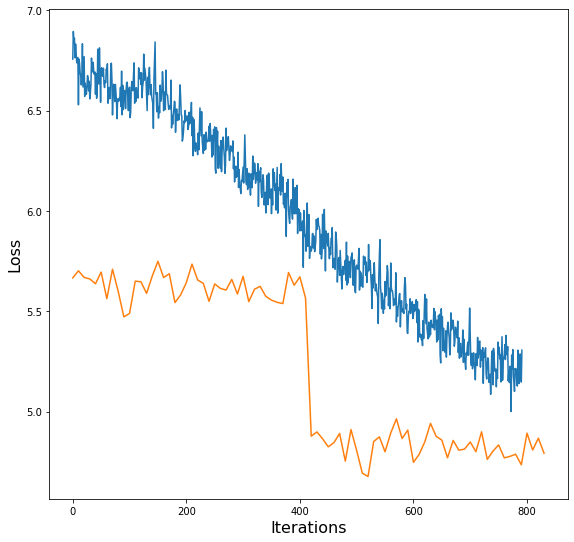

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.subplots_adjust(bottom=.05, top=.9, left=.05, right=.95)

plt.plot(range(len(X1)), X1, np.array(range(len(X2)))*10, X2)
plt.xlabel('Iterations', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.show()

**Predict sentences**
--

In [0]:
def build_sent(model, function, start, end='<eos>', max_len=25):
    eos = TEXT.vocab.stoi[end]
    tok = start
    with tt.no_grad():
        seq = [tok]
        i = 0
        while i < max_len and seq[-1] != eos:
          i += 1
          pred = model(tt.tensor([seq]))[:,:,-1]
          seq.append(function(pred))
    return ' '.join([TEXT.vocab.itos[v] for v in seq])


In [14]:
argmax_case = lambda prob: tt.argmax(prob).item()
for i in range(100):
    print(build_sent(model, argmax_case, start=i))

<unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
<pad> unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk
<eos>
unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk
much much much much much much much much much much much much much much much much much much much much much much much much much much
one <eos>
﻿1 <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
also <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
two <eos>
time ﻿1 <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
year <eos>
use unk

The quality is bad

I will improve as soon as possible:
- SubWord tokenization
- Replace punctuation (.!?) with eos, text preprocessing
- More epochs
- Other inference techniques


